# Exercise n.1

Online Retail Data
Start from this dataset: https://archive.ics.uci.edu/ml/datasets/Online+Retail

Questions:
1. Which products are often bought together? 
2. How would you identify similar customers?
3. 
    - (1) Create a predictive model to estimate the probability that an order is cancelled. Therefor validate and tune three models of your choice.
    - (2) Identify the most important features in the dataset for predicting the cancellation. Quantify the effect of one of them on the cancellation probability


---
# Table of Contents

1. [Raw Data](#data)
    - 1.1 [Download the Dataset](#get_data)
    - 1.2 [Store data as local csv file](#turn_data)
    
2. [EDA](#eda)
    - 2.1 [Load data from csv file](#load_data)
    - 2.2 [Missing data](#missing_data)
    - 2.3 [Unique entities](#unique_entities)
    - 2.4 [StockCode investigation](#stock_code)
 
3. [Q&A](#q&a) 
    - Q#1. [Which products are often bought together?](#q1)
    - Q#2. [How would you identify similar customers?](#q2)
    - Q#3
        - Q#3.1 [Create a predictive model to estimate the probability that an order is cancelled. Therefor validate and tune three models of your choice.](#q31)
        - Q#3.2 [Identify the most important features in the dataset for predicting the cancellation. Quantify the effect of one of them on the cancellation probability](#q32)


---
## Raw Data
### 1.1 Downlaod the data
<a id="get_data"></a>


In [1]:
import urllib.request
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
urllib.request.urlretrieve(data_url, "../data/data.xlsx")

('../data/data.xlsx', <http.client.HTTPMessage at 0x106661e80>)

### 1.2 Store data as local csv file
<a id="turn_data"></a>
####  Read the excel data into memory

In [2]:
from openpyxl import load_workbook
import pandas as pd

def load_data(file_path):
    '''Turn the .xlsx files into pandas data frame
    
    Args:
        file_path (str): path to the local .xlsx file
        
    return:
        df (pd.DataFrame): output dataframe
    '''
    # load .xlsx file
    wb=load_workbook(file_path)
    # activate sheet
    sheet=wb.active
    # get max row and column count
    max_row, max_column = sheet.max_row, sheet.max_column

    # placeholder for the data
    all_rows = []

    # iterate over all cells 
    for i in range(1,max_row+1):
        # temp for each event
        row_value = []
        for j in range(1,max_column+1):
            # get particular cell value    
            cell_obj=sheet.cell(row=i,column=j)
            row_value.append(cell_obj.value)           
        all_rows.append(row_value)


    df = pd.DataFrame(all_rows[1:], columns=all_rows[0])
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    return df

In [3]:
data_path = "../data/data.xlsx"
data = load_data(data_path)

#### Enrich with "is_cancelled" column

In [4]:
def get_cancel_status(invoice_no, val_canceled=1,val_normal=0):
    if 'c' in str(invoice_no).lower():
        return val_canceled
    else:
        return val_normal
    
data['is_cancelled'] = [get_cancel_status(invoice_no) for invoice_no in data['InvoiceNo']]

#### Remove invalid rows
Since the cancelled transaction should have negative quantity value, we remove those transactions that are cancelled but with positive quantity values.

In [5]:
idx_invalid = [get_cancel_status(i,-1,1)*q<=0 for (i,q) in zip(data.InvoiceNo,data.Quantity)]
data.drop(data.index[idx_invalid],inplace=True)

In [6]:
len(data)

540573

####  Save data into csv format
save data so that it is faster to resume

In [7]:
file_path = "../data/data.csv"
data.to_csv(file_path,index=False)

## 2. EDA
<a id="eda"></a>

### 2.1 Load data from csv file
<a id="load_data"></a>
Since it takes some time to parse the excel files, you can speed up by loading the data in the csv format from the local disk.  

In [8]:
from pathlib import Path

data_file = Path(file_path)
if data_file.exists():
    data = pd.read_csv('../data/data.csv')


In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


### 2.2 Missing data
<a id="missing_data"></a>
The "customerID" column has around 25% missing data

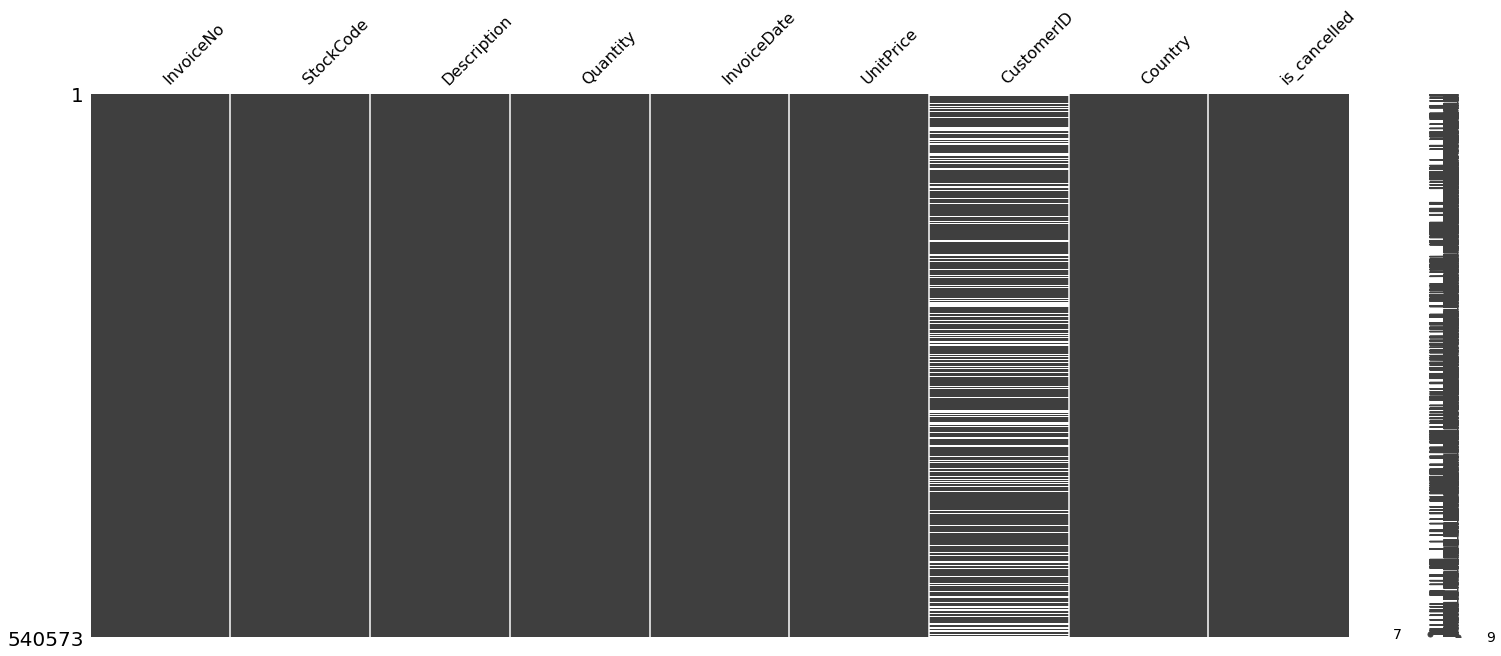

In [12]:
import missingno as msno
msno.matrix(data)

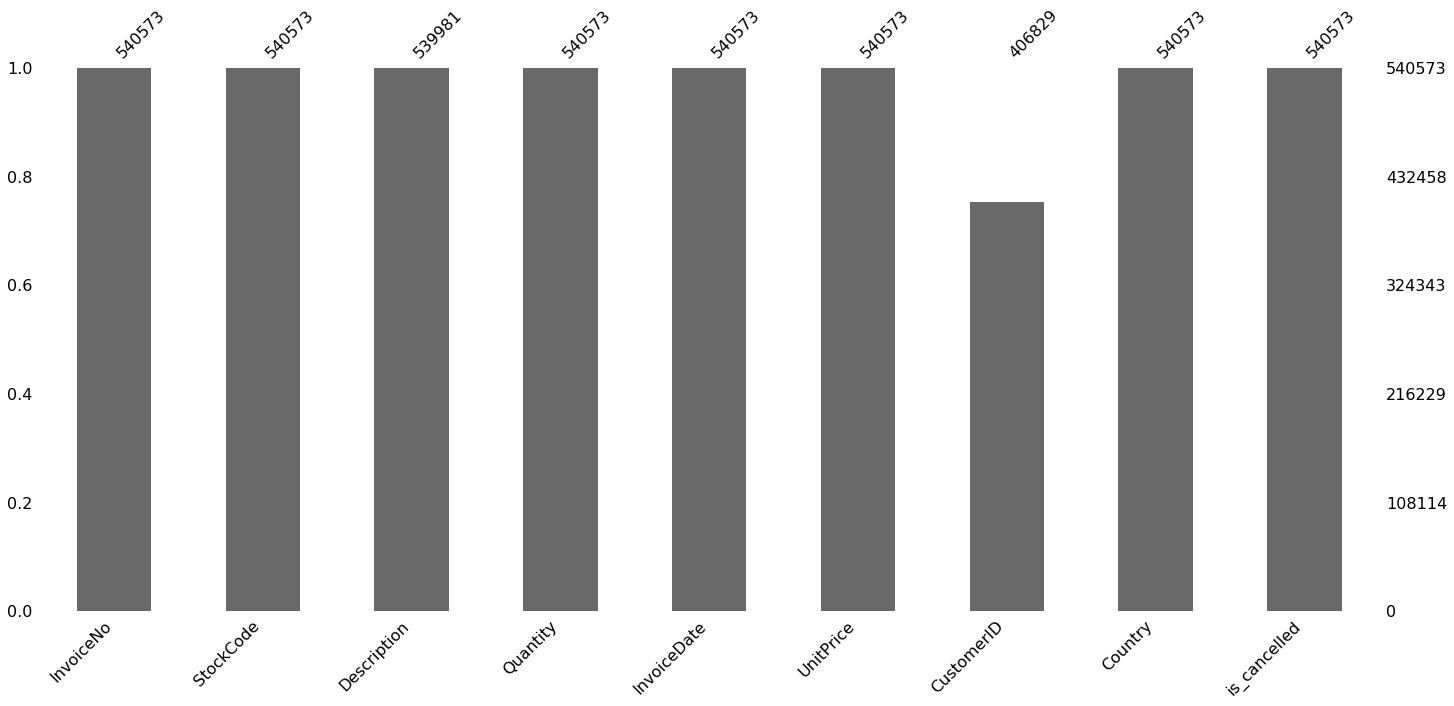

In [11]:
msno.bar(data)

### 2.3 Unique entities
<a id="unique_entities"></a>

In [13]:
num_transactions = len(set(data.InvoiceNo))
num_products = len(set(data.StockCode))
num_customers = len(set(data.dropna().CustomerID))
num_countries = len(set(data.Country))
print('There are:\n\
    {} unique transactions,\n\
    {} unique products,\n\
    {} unique customers,\n\
    {} unique countries'.format(num_transactions,
                                num_products,
                                num_customers,
                                num_countries))

There are:
    24564 unique transactions,
    3957 unique products,
    4372 unique customers,
    38 unique countries


### 2.4 StockCode investigation
<a id="stock_code"></a>

StockCode with same digial code followed by different character are different products (e.g. same product with different color). See the followng example:

In [14]:
idx = data.index['15058A' == data['StockCode']]
set(data.loc[idx]['Description'])

{'BLUE POLKADOT GARDEN PARASOL', nan}

In [15]:
idx = data.index['15058B' == data['StockCode'] ]
set(data.loc[idx]['Description'])

{'PINK POLKADOT GARDEN PARASOL'}

---
## Q&A
<a id="q&a"></a>


## Q1: Which products are often bought together?
<a id="q1"></a>
To answer this question, I would like to contruct the sparse cooccurance matrix of products, which has unique stock code. 

To build such a matrix, we need to build a mapping from stock code to row/column index in the matrix. Then sort the tuple of (product#1, product#2, number of purchase where product#1 and product#2 appeared together).

#### 1. Build the following three mappings:
- a, mapping from stock code to index
- b. mapping from invoice number to index
- c. mapping from stock code to description

Mapping **a** and **b** are used during the matrix contruction. Mapping **c** is used to make sense the result.


In [16]:
unique_stock_code = list(set(data.StockCode))
mapping_idx2stock_code = dict(enumerate(unique_stock_code))
mapping_stock_code2idx = {v: k for k, v in mapping_idx2stock_code.items()}

In [17]:
unique_invoice_number = list(set(data.InvoiceNo))
mapping_idx2invoice_number = dict(enumerate(unique_invoice_number))
mapping_invoice_number2idx = {v: k for k, v in mapping_idx2invoice_number.items()}

In [18]:
mapping_stock_code2description = dict(zip(data.StockCode,data.Description))

#### 2. Group stock code according to the invoice number. We assume each purchase has its own invoice number.

In [19]:
purchases = data[["InvoiceNo","StockCode"]].groupby("InvoiceNo").agg({'StockCode':lambda x: list(x)})

In [21]:
# map StockCode to their index, return array with invoice number, and list of StockCodeIndex
vals = purchases.StockCode.apply(lambda purchase: list(map(lambda stock_code: mapping_stock_code2idx.get(stock_code), purchase))).reset_index().values
# construct a tuple list of the form (invoice number index, stock_code_index, 1) 
invoice_stock_one = [(mapping_invoice_number2idx.get(row[0]), stock, 1) for row in vals for stock in row[1]]

In [23]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix,triu

rows, cols, val = map(np.array, zip(*invoice_stock_one))
invoice_stock_matrix = coo_matrix((val, (rows, cols)))

In [24]:
# co-occurence matrix
ism = invoice_stock_matrix.tocsr()
ismt = ism.transpose()
co_oc = ismt*ism

# since we are interested to pair of products, we ignore the count of purchases of a single product
co_oc.setdiag(0)
co_oc.eliminate_zeros()

In [25]:
# Construct output
co_oc_out = co_oc.tocoo()
# Remove the duplicated pairs due to symmetry
co_oc_out = triu(co_oc_out,1) 
output = list(zip(zip(co_oc_out.row, co_oc_out.col), co_oc_out.data))

In [28]:
output_translated = [((mapping_stock_code2description.get(i),mapping_stock_code2description.get(j)),v)for ((i,j),v) in output_translated]

In [29]:
output_translated.sort(key=lambda tup: tup[1],reverse=True)

In [34]:
print("The top 10 pairs of products which are \n\
bought together most frequently are the following:")
output_translated[:10]

The top 10 pairs of products which are 
bought together most frequently are the following:


[(('PINK REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'), 905),
 (('JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT'), 871),
 (('ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER'),
  861),
 (('JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT'), 756),
 (('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED '), 711),
 (('LUNCH BAG  BLACK SKULL.', 'LUNCH BAG RED RETROSPOT'), 705),
 (('LUNCH BAG SUKI DESIGN ', 'LUNCH BAG RED RETROSPOT'), 703),
 (('JUMBO BAG RED RETROSPOT', 'JUMBO SHOPPER VINTAGE RED PAISLEY'), 697),
 (('ROSES REGENCY TEACUP AND SAUCER ', 'PINK REGENCY TEACUP AND SAUCER'), 693),
 (('LUNCH BAG RED RETROSPOT', 'LUNCH BAG PINK POLKADOT'), 654)]

#### 3. power-law distribution of the count of co occurance of products

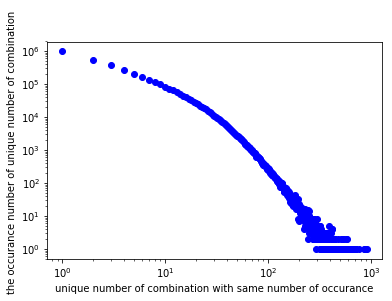

In [37]:
import matplotlib.pyplot as plt
from collections import Counter
_,values = zip(*output_translated)
c = Counter(values)
# power law distribution of (coutry, product) counts
plt.loglog(c.keys(),c.values(),'bo')
plt.xlabel('unique number of combination with same number of occurance')
plt.ylabel('the occurance number of unique number of combination ')
plt.show()

## Q2: How would you identify similar customers?
<a id="q2"></a>

##### Main idea: 

- Step 1: First generate the matrix that store the count of purchase by certain customer on certain product, where rows corresponds to customer and columns corresponds to products(stock code). 
- Step 2: Then use the row of the matrix as the representation of the customer
- Setp 3: use the cosince distance between representations of customers as the distance metrics

##### Results:
- Clustering customers with spectrual clustering algorithm with the pairwise similarity matrix of custommers (1- cosine distance matrix)
- visualize the customers with PCA and T-SNE
- A look up function to retrieve the top k similar customers to a provided customer

#### 1. Construct the tuple list ((customer, product), number of purchase)

In [38]:
unique_customer_id = set([int(id) for id in list(data.dropna().CustomerID)])

In [39]:
mapping_customer_id2idx = {k: v for k, v in zip(unique_customer_id,range(len(unique_customer_id)))}
mapping_idx2customer_id = {v: k for k, v in zip(unique_customer_id,range(len(unique_customer_id)))}

In [41]:
customer_stock_one = [((mapping_customer_id2idx.get(c),mapping_stock_code2idx.get(s)) , 1) for (c,s) in zip(data.dropna().CustomerID,data.dropna().StockCode)]

In [42]:
customer_stock_count = {}
for ((customer,stock),val) in customer_stock_one:
    if (customer,stock) not in customer_stock_count.keys():
        customer_stock_count[(customer,stock)]=val
    else:
        customer_stock_count[(customer,stock)]+=val

#### 2. Power law distribution of (coutry, product) counts

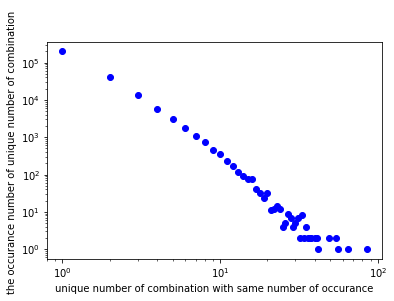

In [43]:
from collections import Counter

c = Counter(customer_stock_count.values())

plt.loglog(c.keys(),c.values(),'bo')
plt.xlabel('unique number of combination with same number of occurance')
plt.ylabel('the occurance number of unique number of combination ')
plt.show()

#### 3. construct the sparse matrix 

In [44]:
customer_stock_count = list(customer_stock_count.items())

In [45]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix

customer_stock, val= zip(*customer_stock_count)
rows, cols  = map(np.array, zip(*customer_stock))
val = np.array(val)
customer_stock_matrix = coo_matrix((val, (rows, cols)))

In [46]:
# co-occurence matrix
csm = customer_stock_matrix.tocsr()
csmt = csm.transpose()
co_oc = csm*csmt

In [47]:
customer_stock_matrix_dense = customer_stock_matrix.todense()

#### 4. Clustering

To speed up, we only analyze a subset of data here.

In [69]:
idx = np.random.choice(len(unique_customer_id),1000)

##### spectrual clustering

In [74]:
from sklearn.metrics import pairwise_distances

sub_matrix = customer_stock_matrix_dense[idx,:]
sub_unique_customer_id = np.array(list(unique_customer_id))[idx]
distance_matrix = pairwise_distances(sub_matrix, sub_matrix, metric='cosine')
similarity_matrix = 1 - distance_matrix

In [75]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(3, 
                        affinity='precomputed', 
                        n_init=100,
                        assign_labels='discretize') 
clusters = sc.fit_predict(similarity_matrix) 


#### 5 Visualization of customer relationship

##### a. PCA visualization


In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(sub_matrix)

x_pca = pca_result[:,0]
y_pca = pca_result[:,1] 


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.12024395 0.05543146]


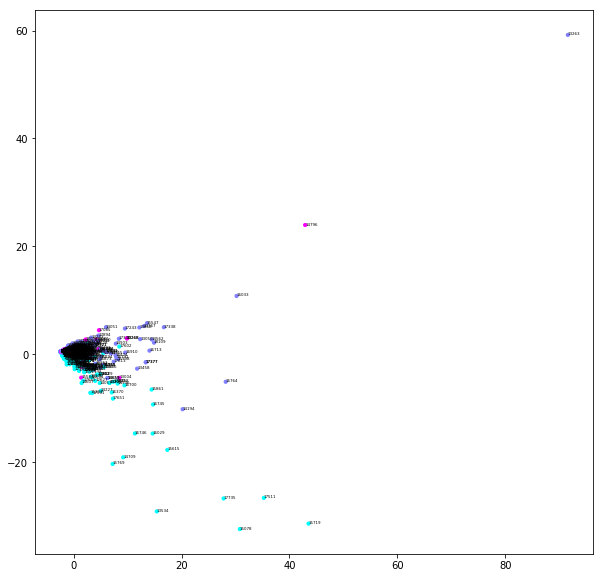

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_pca, y_pca, c=clusters, cmap=plt.cm.cool,s=10)

for i, txt in enumerate(sub_unique_customer_id):
    ax.annotate(txt, (x_pca[i], y_pca[i]),size=4)

##### b. TSNE visualization

In [82]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.222566
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.335915
[t-SNE] Error after 1000 iterations: 1.418350
t-SNE done! Time elapsed: 38.991081953048706 seconds


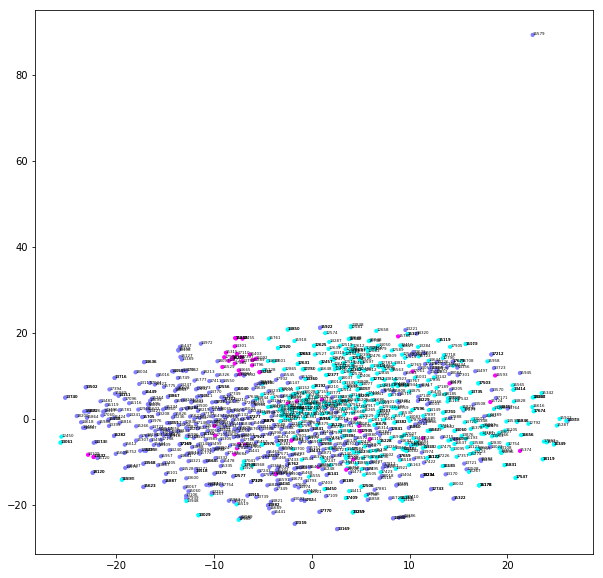

In [87]:
import matplotlib.pyplot as plt
x_tsne= tsne_results[:,0]
y_tsne = tsne_results[:,1]


fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_tsne, y_tsne, c=clusters, cmap=plt.cm.cool,s=10)

for i, txt in enumerate(sub_unique_customer_id):
    ax.annotate(txt, (x_tsne[i], y_tsne[i]),size=4)

#### 6. Look up function to get most similar customer given one customer

In [89]:
distance_matrix = pairwise_distances(customer_stock_matrix_dense, customer_stock_matrix_dense, metric='cosine')
similarity_matrix = 1 - distance_matrix

In [98]:
def lookup_most_similar_customer(customer_id, k=10):
    c_idx = mapping_customer_id2idx.get(customer_id)
    s = similarity_matrix[c_idx,:]
    idx_sorted = np.argsort(s)
    top_k_customer_id = [mapping_idx2customer_id.get(idx) for idx in idx_sorted]
    return top_k_customer_id[:k]

In [102]:
lookup_most_similar_customer(list(unique_customer_id)[1])

[16384, 13366, 13368, 13372, 13376, 13382, 13385, 13391, 13395, 13397]

## Q3.1: 
## Create a predictive model to estimate the probability that an order is cancelled. Therefor validate and tune three models of your choice.
<a id="q31"></a>

In [116]:
ism = invoice_stock_matrix.tocsr()
sim = ism.transpose()
ssm = sim*ism

In [117]:
csm = customer_stock_matrix.tocsr()
scm = csm.transpose()

#### Construct stock code to country coocurance matrix

In [103]:
unique_countries = set(list(data.Country))

In [104]:
mapping_country2idx = {k: v for k, v in zip(unique_countries,range(len(unique_countries)))}
mapping_idx2country = {v: k for k, v in zip(unique_countries,range(len(unique_countries)))}

In [105]:
country_stock_one = [((mapping_country2idx.get(c),mapping_stock_code2idx.get(s)) , 1) for (c,s) in zip(data.Country,data.StockCode)]

In [109]:
country_stock_count = {}
for ((country,stock),val) in country_stock_one:
    if (country,stock) not in country_stock_count.keys():
        country_stock_count[(country,stock)]=val
    else:
        country_stock_count[(country,stock)]+=val

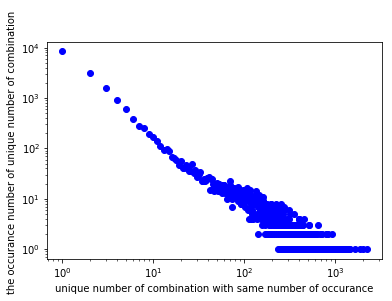

In [110]:
from collections import Counter

c = Counter(country_stock_count.values())
# power law distribution of (coutry, product) counts
plt.loglog(c.keys(),c.values(),'bo')
plt.xlabel('unique number of combination with same number of occurance')
plt.ylabel('the occurance number of unique number of combination ')
plt.show()

In [112]:
country_stock_count = list(country_stock_count.items())

In [113]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix


country_stock, val= zip(*country_stock_count)
rows, cols  = map(np.array, zip(*country_stock))
val = np.array(val)
country_stock_matrix = coo_matrix((val, (rows, cols)))

In [114]:
lsm = country_stock_matrix.tocsr()#location_2_stock_code
lsmt = lsm.transpose()

#### construct embeddings: decentralized alternative least square algorithm

In [118]:
from scipy.sparse import bmat
co_oc = bmat([[ssm],[csm],[lsm]])

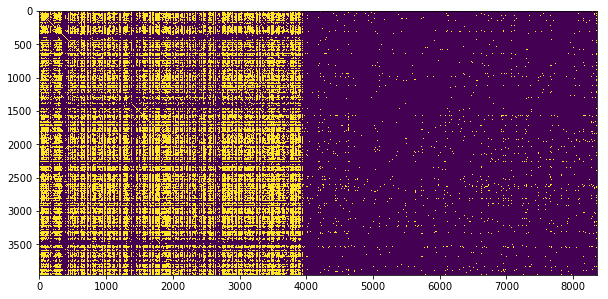

In [120]:
plt.figure(figsize=(10,30))
#plt.colorbar(c)
plt.imshow(co_oc.todense().T>0)

plt.show()

In [121]:
a,b = csm.shape
sparcity = np.sum(csm.todense()>0)/(a*b)
print('The sparsity of the matrix of customer to stock code is: {}'.format(sparcity))

The sparsity of the matrix of customer to stock code is: 0.015469071567844724


In [122]:
a,b = lsm.shape
sparcity = np.sum(lsm.todense()>0)/(a*b)
print('The sparsity of the matrix of country to customer to stock code is: {}'.format(sparcity))

The sparsity of the matrix of country to customer to stock code is: 0.13117327055318356


In [123]:
a,b = ssm.shape
sparcity = np.sum(ssm.todense()>0)/(a*b)
print('The sparsity of the matrix of stock code to stock code is: {}'.format(sparcity))

The sparsity of the matrix of stock code to stock code is: 0.4794470172754891


#### Matrix factorization

In [306]:
A = co_oc.todense()
A = np.log(A+1)
U, s, V = np.linalg.svd(co_oc.todense(), full_matrices=True)
print(U.shape, V.shape, s.shape)

(8480, 8480) (4070, 4070) (4070,)


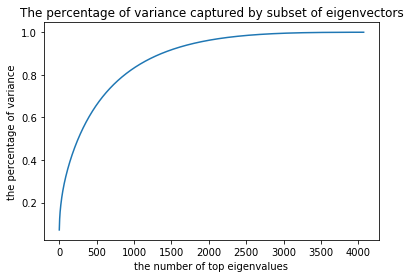

In [307]:
plt.plot(np.cumsum(s)/np.sum(s))
plt.title('The percentage of variance captured by subset of eigenvectors')
plt.xlabel('the number of top eigenvalues')
plt.ylabel('the percentage of variance')
plt.show()

#### create embedding of transaction

In [308]:
dim_keep = 100
embedings_stock = U[:len(unique_stock_code),:dim_keep]
embedings_customer = U[len(unique_stock_code):(len(unique_stock_code)+len(unique_customer_id)),:dim_keep]
embedings_country = U[(len(unique_stock_code)+len(unique_customer_id)):,:dim_keep]

In [360]:
np.mean(embedings_country)

-0.0005208037194334262

In [361]:
np.std(embedings_country)

0.015104382396053447

In [311]:
embedings_country.shape

(38, 100)

In [396]:
data_sub = data[["StockCode","CustomerID","Country","Quantity","UnitPrice","is_cancelled"]]
data_sub_dropna = data_sub.dropna()

In [373]:
quantity_mean = np.mean(np.abs(data.Quantity))

In [374]:
quantity_std = np.std(np.abs(data.Quantity))

In [375]:
unit_price_mean = np.mean(np.abs(data.UnitPrice))

In [376]:
unit_price_std = np.std(np.abs(data.UnitPrice))

In [397]:
label = np.array(data_sub_dropna.is_cancelled)

In [354]:
num_trans = len(data_sub_dropna)
output = np.zeros((num_trans,3*dim_keep+2))
for i in range(num_trans):
    trans = data_sub_dropna.iloc[i]
    c,s,l = trans.CustomerID,trans.StockCode,trans.Country 
    
    c_idx = mapping_customer_id2idx.get(c)
    s_idx = mapping_stock_code2idx.get(s)
    l_idx = mapping_country2idx.get(l)
    
    output[i,:dim_keep] = embedings_customer[c_idx,:]
    output[i,dim_keep:(2*dim_keep)] = embedings_stock[s_idx,:]
    output[i,2*dim_keep:3*dim_keep] = embedings_country[l_idx,:]
    output[i,-2] = (np.abs(trans.Quantity)- quantity_mean)/(quantity_std*100)
    output[i,-1] = (trans.UnitPrice- unit_price_mean)/(unit_price_std*100)
    

In [563]:
np.save('../data/data',output)

In [564]:
np.save('../data/label',label)

### Modeling

In [610]:
data_np = np.load('../data/data.npy')
label_np = np.load('../data/label.npy')

In [566]:
label_np= label_np.reshape((-1,1))

In [567]:
label_np.shape

(406829, 1)

#### split data into train valid test

In [611]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_np, label_np, test_size=0.33, random_state=42)

In [569]:
X_train.shape

(272575, 302)

In [570]:
y_test

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [571]:
import tensorflow as tf

#### a. Logistic regression

In [572]:
import tensorflow as tf


# Parameters
learning_rate = 0.001
training_epochs = 50
batch_size = 100
display_step = 1

graph = tf.Graph()
with graph.as_default():
    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, 302]) # mnist data image of shape 28*28=784
    y = tf.placeholder(tf.float32, [None,1]) # 0-9 digits recognition => 10 classes

    # Set model weights
    W = tf.get_variable("W", (302,1),initializer=tf.random_normal_initializer())
    b = tf.get_variable("b", (1),initializer=tf.random_normal_initializer())

    # Construct model
    logits = tf.matmul(x, W) + b
    pred = tf.nn.sigmoid(logits) 

    # Minimize error using cross entropy
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(X_train.shape[0]/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_idx = np.random.choice(X_train.shape[0], batch_size)

                batch_xs, batch_ys = X_train[batch_idx,],y_train[batch_idx]
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                              y: batch_ys})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if (epoch+1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

        print("Optimization Finished!")

        # Test model
        #correct_prediction = tf.equal(pred>0.5, y)
        # Calculate accuracy
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        y_score_lg = pred.eval({x: X_test, y: y_test})

   
    


Epoch: 0001 cost= 0.552777424
Epoch: 0002 cost= 0.170347838
Epoch: 0003 cost= 0.113357740
Epoch: 0004 cost= 0.105589252
Epoch: 0005 cost= 0.105139963
Epoch: 0006 cost= 0.104280023
Epoch: 0007 cost= 0.105725238
Epoch: 0008 cost= 0.105103327
Epoch: 0009 cost= 0.106837014
Epoch: 0010 cost= 0.104677985
Epoch: 0011 cost= 0.106880765
Epoch: 0012 cost= 0.106462256
Epoch: 0013 cost= 0.104435184
Epoch: 0014 cost= 0.105833626
Epoch: 0015 cost= 0.105255279
Epoch: 0016 cost= 0.104772911
Epoch: 0017 cost= 0.106003341
Epoch: 0018 cost= 0.105455459
Epoch: 0019 cost= 0.104766209
Epoch: 0020 cost= 0.106423191
Epoch: 0021 cost= 0.105835575
Epoch: 0022 cost= 0.104025319
Epoch: 0023 cost= 0.104939975
Epoch: 0024 cost= 0.105876660
Epoch: 0025 cost= 0.105640560
Epoch: 0026 cost= 0.108509380
Epoch: 0027 cost= 0.107278837
Epoch: 0028 cost= 0.107637716
Epoch: 0029 cost= 0.106038462
Epoch: 0030 cost= 0.105298304
Epoch: 0031 cost= 0.105921202
Epoch: 0032 cost= 0.103639699
Epoch: 0033 cost= 0.104629500
Epoch: 003

In [573]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc

fpr_lg, tpr_lg, _ = roc_curve(y_test, y_score_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)
    
y_pred_lg = y_score_lg>0.5
print(accuracy_score(y_test, y_pred_lg))
print(precision_score(y_test, y_pred_lg))
print(recall_score(y_test, y_pred_lg))
print(roc_auc_score(y_test, y_score_lg))
print(confusion_matrix(y_test, y_pred_lg))

0.9784810880867609
0.4
0.0006925207756232687
0.6031540194651023
[[131363      3]
 [  2886      2]]


### random guess

In [574]:
y_score_rand= np.random.rand(len(y_test),1)

In [575]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc

fpr_rand, tpr_rand, _ = roc_curve(y_test, y_score_rand)
roc_auc_rand = auc(fpr_rand, tpr_rand)
    
y_pred_rand = y_score_rand>0.5
print(accuracy_score(y_test, y_pred_rand))
print(precision_score(y_test, y_pred_rand))
print(recall_score(y_test, y_pred_rand))
print(roc_auc_score(y_test, y_score_rand))
print(confusion_matrix(y_test, y_pred_rand))

0.500908725252134
0.021322025293775103
0.49445983379501385
0.4958050714539569
[[65821 65545]
 [ 1460  1428]]


#### Neural Network

In [576]:
import tensorflow as tf

def NN(X_train,X_test,y_train,y_test,input_dim=302):


    # Parameters
    learning_rate = 0.001
    training_epochs = 50
    batch_size = 100
    display_step = 1
    h1 = 10
    h2 = 10
    h3 = 10

    graph = tf.Graph()
    with graph.as_default():

        # tf Graph Input
        x = tf.placeholder(tf.float32, [None, input_dim]) # mnist data image of shape 28*28=784
        y = tf.placeholder(tf.float32, [None,1]) # 0-9 digits recognition => 10 classes

        # Set model weights
        W1 = tf.get_variable("W1", (input_dim,h1),initializer=tf.random_normal_initializer())
        b1 = tf.get_variable("b1", (h1),initializer=tf.random_normal_initializer())

        W2 = tf.get_variable("W2",(h1, h2),initializer=tf.random_normal_initializer())
        b2 = tf.get_variable("b2",(h2),initializer=tf.random_normal_initializer())

        W3 = tf.get_variable("W3",(h2, h3),initializer=tf.random_normal_initializer())
        b3 = tf.get_variable("b3", (h3),initializer=tf.random_normal_initializer())

        W4 = tf.get_variable("W4", (h1,1),initializer=tf.random_normal_initializer())
        b4 = tf.get_variable("b4", (1),initializer=tf.random_normal_initializer())


        # Construct model
        z1 = tf.matmul(x, W1) + b1
        z1 = tf.nn.selu(z1)

        z2 = tf.matmul(z1, W2) + b2
        z2 = tf.nn.selu(z2)

        z3 = tf.matmul(z2, W3) + b3
        z3 = tf.nn.selu(z3)

        logits = tf.matmul(z3, W4) + b4

        pred = tf.nn.sigmoid(logits) 

        # Minimize error using cross entropy
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
        # Gradient Descent
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            # Training cycle
            for epoch in range(training_epochs):
                avg_cost = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                # Loop over all batches
                for i in range(total_batch):
                    batch_idx = np.random.choice(X_train.shape[0], batch_size)

                    batch_xs, batch_ys = X_train[batch_idx,],y_train[batch_idx]
                    # Run optimization op (backprop) and cost op (to get loss value)
                    _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                                  y: batch_ys})
                    # Compute average loss
                    avg_cost += c / total_batch
                # Display logs per epoch step
                if (epoch+1) % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

            print("Optimization Finished!")

            # Test model
            #correct_prediction = tf.equal(pred>0.5, y)
            # Calculate accuracy
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            y_score_nn = pred.eval({x: X_test, y: y_test})
            return y_score_nn





In [577]:
y_score_nn = NN(X_train,X_test,y_train,y_test)

Epoch: 0001 cost= 0.106215527
Epoch: 0002 cost= 0.107737739
Epoch: 0003 cost= 0.105953932
Epoch: 0004 cost= 0.105744667
Epoch: 0005 cost= 0.106136469
Epoch: 0006 cost= 0.107459944
Epoch: 0007 cost= 0.105760118
Epoch: 0008 cost= 0.104968387
Epoch: 0009 cost= 0.104481084
Epoch: 0010 cost= 0.104438896
Epoch: 0011 cost= 0.105548497
Epoch: 0012 cost= 0.105188489
Epoch: 0013 cost= 0.106287809
Epoch: 0014 cost= 0.105917435
Epoch: 0015 cost= 0.106201573
Epoch: 0016 cost= 0.105797926
Epoch: 0017 cost= 0.104989047
Epoch: 0018 cost= 0.104985766
Epoch: 0019 cost= 0.106459759
Epoch: 0020 cost= 0.105229044
Epoch: 0021 cost= 0.105443179
Epoch: 0022 cost= 0.105380950
Epoch: 0023 cost= 0.104413509
Epoch: 0024 cost= 0.105844451
Epoch: 0025 cost= 0.104091956
Epoch: 0026 cost= 0.104265347
Epoch: 0027 cost= 0.104181891
Epoch: 0028 cost= 0.106350418
Epoch: 0029 cost= 0.104742240
Epoch: 0030 cost= 0.105310773
Epoch: 0031 cost= 0.104897400
Epoch: 0032 cost= 0.103931018
Epoch: 0033 cost= 0.104449107
Epoch: 003

In [578]:
def evaluate(y_score_nn):
    from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix

    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
    roc_auc_nn = auc(fpr_nn, tpr_nn)

    y_pred_nn = y_score_nn>0.5
    print("accuracy: ",accuracy_score(y_test, y_pred_nn))
    print("precision: ",precision_score(y_test, y_pred_nn))
    print("recall: ", recall_score(y_test, y_pred_nn))
    print("roc: ", roc_auc_score(y_test, y_score_nn))
    print("confusion matrix: \n",confusion_matrix(y_test, y_pred_nn))

In [581]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

y_pred_nn = y_score_nn>0.5
print("accuracy: ",accuracy_score(y_test, y_pred_nn))
print("precision: ",precision_score(y_test, y_pred_nn))
print("recall: ", recall_score(y_test, y_pred_nn))
print("roc: ", roc_auc_score(y_test, y_score_nn))
print("confusion matrix: \n",confusion_matrix(y_test, y_pred_nn))

accuracy:  0.97846619095148
precision:  0.0
recall:  0.0
roc:  0.6194545607874943
confusion matrix: 
 [[131363      3]
 [  2888      0]]


#### XGBoost

In [612]:
from xgboost import XGBClassifier
model = XGBClassifier()

In [613]:
model.fit(X_train, y_train.reshape(-1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [614]:
y_pred_xgb = model.predict(X_test)

/Users/narisutao/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [615]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix
print("accuracy: ",accuracy_score(y_test, y_pred_xgb))
print("precision: ",precision_score(y_test, y_pred_xgb))
print("recall: ", recall_score(y_test, y_pred_xgb))
print("confusion matrix: \n",confusion_matrix(y_test, y_pred_xgb))

accuracy:  0.9785108823573226
precision:  0.5348837209302325
recall:  0.00796398891966759
confusion matrix: 
 [[131346     20]
 [  2865     23]]


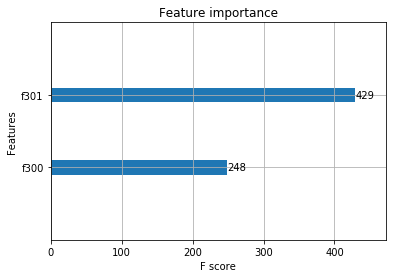

In [617]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

### comparison between models performance

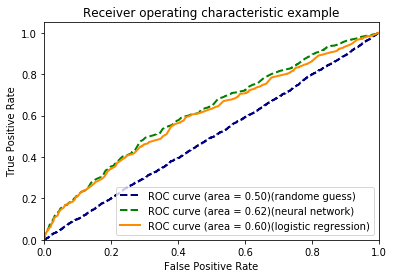

In [582]:
plt.figure()
lw = 2
plt.plot(fpr_rand, tpr_rand, color='navy',linestyle='--',
         lw=lw, label='ROC curve (area = %0.2f)(randome guess)' % roc_auc_rand)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_nn, tpr_nn, color='green',linestyle='--',
         lw=lw, label='ROC curve (area = %0.2f)(neural network)' % roc_auc_nn)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_lg, tpr_lg, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)(logistic regression)' % roc_auc_lg)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Next step:
1. Replace the SVD with decentralized alternative least squre algorithm so that the embedding learning can be scaled up to even larger data set.
2. Parse time into local time given the courntry, and generate hour, working day, holiday, features. Finally, create embedding out of these features.
3. Incoperate the quantity and unit price into the cooccurance matrix construction.

---
## Q3.2: 
## Identify the most important features in the dataset for predicting the cancellation. Quantify the effect of one of them on the cancellation probability
<a id="q32"></a>

- **Idea**: we will exclude one feature at a time and evalue the model performance. When we remove the most import feature, we would see the biggest performance drop.

#### 1. Isolate unit price

In [583]:
data_np_tmp = data_np[:,:-1]

In [584]:
data_np[:,:-1].shape

(406829, 301)

In [585]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=301)
evaluate(y_score_nn)

Epoch: 0001 cost= 0.107140247
Epoch: 0002 cost= 0.107224775
Epoch: 0003 cost= 0.105743815
Epoch: 0004 cost= 0.107116896
Epoch: 0005 cost= 0.106367944
Epoch: 0006 cost= 0.107687576
Epoch: 0007 cost= 0.107848820
Epoch: 0008 cost= 0.107705138
Epoch: 0009 cost= 0.105602851
Epoch: 0010 cost= 0.107054661
Epoch: 0011 cost= 0.106156993
Epoch: 0012 cost= 0.105901000
Epoch: 0013 cost= 0.107256597
Epoch: 0014 cost= 0.106554810
Epoch: 0015 cost= 0.108212325
Epoch: 0016 cost= 0.104906970
Epoch: 0017 cost= 0.106097837
Epoch: 0018 cost= 0.107308358
Epoch: 0019 cost= 0.107487257
Epoch: 0020 cost= 0.105250448
Epoch: 0021 cost= 0.105538260
Epoch: 0022 cost= 0.105114690
Epoch: 0023 cost= 0.106078080
Epoch: 0024 cost= 0.105711524
Epoch: 0025 cost= 0.107990280
Epoch: 0026 cost= 0.106079399
Epoch: 0027 cost= 0.106891091
Epoch: 0028 cost= 0.106203223
Epoch: 0029 cost= 0.107546798
Epoch: 0030 cost= 0.107902004
Epoch: 0031 cost= 0.104744144
Epoch: 0032 cost= 0.105868374
Epoch: 0033 cost= 0.107172653
Epoch: 003

/Users/narisutao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion matrix: 
 [[131366      0]
 [  2888      0]]


#### 2. Isolate quantity

In [586]:
data_np_tmp = np.concatenate((data_np[:,:-2],data_np[:,-1].reshape(-1,1)),axis=1)

In [587]:
data_np_tmp.shape

(406829, 301)

In [588]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=301)
evaluate(y_score_nn)

Epoch: 0001 cost= 0.108765993
Epoch: 0002 cost= 0.106147383
Epoch: 0003 cost= 0.105099457
Epoch: 0004 cost= 0.104606614
Epoch: 0005 cost= 0.104738038
Epoch: 0006 cost= 0.107958640
Epoch: 0007 cost= 0.104104794
Epoch: 0008 cost= 0.105016581
Epoch: 0009 cost= 0.108413106
Epoch: 0010 cost= 0.106978690
Epoch: 0011 cost= 0.104697847
Epoch: 0012 cost= 0.107480033
Epoch: 0013 cost= 0.104249935
Epoch: 0014 cost= 0.105320552
Epoch: 0015 cost= 0.105948972
Epoch: 0016 cost= 0.105504832
Epoch: 0017 cost= 0.103298487
Epoch: 0018 cost= 0.106750359
Epoch: 0019 cost= 0.105430465
Epoch: 0020 cost= 0.106074779
Epoch: 0021 cost= 0.106928015
Epoch: 0022 cost= 0.104385692
Epoch: 0023 cost= 0.106676473
Epoch: 0024 cost= 0.105366023
Epoch: 0025 cost= 0.106183263
Epoch: 0026 cost= 0.106347412
Epoch: 0027 cost= 0.105164162
Epoch: 0028 cost= 0.106066496
Epoch: 0029 cost= 0.104880043
Epoch: 0030 cost= 0.105269258
Epoch: 0031 cost= 0.106824157
Epoch: 0032 cost= 0.106209900
Epoch: 0033 cost= 0.106360490
Epoch: 003

#### 3. Isolate customer id

In [589]:
data_np_tmp = data_np[:,100:]

In [590]:
data_np_tmp.shape

(406829, 202)

In [591]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=202)
evaluate(y_score_nn)

Epoch: 0001 cost= 0.108843034
Epoch: 0002 cost= 0.106299180
Epoch: 0003 cost= 0.106287797
Epoch: 0004 cost= 0.106201767
Epoch: 0005 cost= 0.105617861
Epoch: 0006 cost= 0.106251858
Epoch: 0007 cost= 0.106665554
Epoch: 0008 cost= 0.106647272
Epoch: 0009 cost= 0.105408842
Epoch: 0010 cost= 0.105792616
Epoch: 0011 cost= 0.105118654
Epoch: 0012 cost= 0.106320424
Epoch: 0013 cost= 0.106141685
Epoch: 0014 cost= 0.104885537
Epoch: 0015 cost= 0.107463233
Epoch: 0016 cost= 0.103082023
Epoch: 0017 cost= 0.104412442
Epoch: 0018 cost= 0.103270353
Epoch: 0019 cost= 0.105014582
Epoch: 0020 cost= 0.105351839
Epoch: 0021 cost= 0.104969413
Epoch: 0022 cost= 0.105342966
Epoch: 0023 cost= 0.105238431
Epoch: 0024 cost= 0.105847641
Epoch: 0025 cost= 0.104500766
Epoch: 0026 cost= 0.105843568
Epoch: 0027 cost= 0.104656028
Epoch: 0028 cost= 0.103311952
Epoch: 0029 cost= 0.105727429
Epoch: 0030 cost= 0.105572411
Epoch: 0031 cost= 0.103757611
Epoch: 0032 cost= 0.102953146
Epoch: 0033 cost= 0.105881505
Epoch: 003

#### 4. Isolate stock code

In [592]:
data_np_tmp = np.concatenate((data_np[:,:100],data_np[:,200:]),axis=1)

In [593]:
data_np_tmp.shape

(406829, 202)

In [594]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=202)
evaluate(y_score_nn)

Epoch: 0001 cost= 0.118218006
Epoch: 0002 cost= 0.108221317
Epoch: 0003 cost= 0.108781316
Epoch: 0004 cost= 0.106475523
Epoch: 0005 cost= 0.105413461
Epoch: 0006 cost= 0.105371499
Epoch: 0007 cost= 0.106462469
Epoch: 0008 cost= 0.106137389
Epoch: 0009 cost= 0.106158259
Epoch: 0010 cost= 0.106788480
Epoch: 0011 cost= 0.106552695
Epoch: 0012 cost= 0.104325915
Epoch: 0013 cost= 0.105730430
Epoch: 0014 cost= 0.106478778
Epoch: 0015 cost= 0.104668674
Epoch: 0016 cost= 0.104833560
Epoch: 0017 cost= 0.105977773
Epoch: 0018 cost= 0.103542788
Epoch: 0019 cost= 0.105388132
Epoch: 0020 cost= 0.104797719
Epoch: 0021 cost= 0.103959274
Epoch: 0022 cost= 0.105378880
Epoch: 0023 cost= 0.102107146
Epoch: 0024 cost= 0.107105552
Epoch: 0025 cost= 0.103834909
Epoch: 0026 cost= 0.105825256
Epoch: 0027 cost= 0.105786081
Epoch: 0028 cost= 0.103515497
Epoch: 0029 cost= 0.103584009
Epoch: 0030 cost= 0.104511076
Epoch: 0031 cost= 0.105202563
Epoch: 0032 cost= 0.105390226
Epoch: 0033 cost= 0.105415620
Epoch: 003

#### 5. Isolate country

In [595]:
data_np_tmp = np.concatenate((data_np[:,:200],data_np[:,300:]),axis=1)

In [596]:
data_np_tmp.shape

(406829, 202)

In [597]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=202)
evaluate(y_score_nn)

Epoch: 0001 cost= 0.145194718
Epoch: 0002 cost= 0.105904318
Epoch: 0003 cost= 0.107695829
Epoch: 0004 cost= 0.104171376
Epoch: 0005 cost= 0.103326725
Epoch: 0006 cost= 0.106832473
Epoch: 0007 cost= 0.106571103
Epoch: 0008 cost= 0.104945454
Epoch: 0009 cost= 0.104675534
Epoch: 0010 cost= 0.105144844
Epoch: 0011 cost= 0.104361730
Epoch: 0012 cost= 0.104266372
Epoch: 0013 cost= 0.105010389
Epoch: 0014 cost= 0.106009490
Epoch: 0015 cost= 0.102933988
Epoch: 0016 cost= 0.106386665
Epoch: 0017 cost= 0.105175760
Epoch: 0018 cost= 0.106049837
Epoch: 0019 cost= 0.104947247
Epoch: 0020 cost= 0.105178417
Epoch: 0021 cost= 0.106043152
Epoch: 0022 cost= 0.104474120
Epoch: 0023 cost= 0.105574705
Epoch: 0024 cost= 0.105555850
Epoch: 0025 cost= 0.105324461
Epoch: 0026 cost= 0.105071057
Epoch: 0027 cost= 0.103031044
Epoch: 0028 cost= 0.102731350
Epoch: 0029 cost= 0.103892497
Epoch: 0030 cost= 0.104938466
Epoch: 0031 cost= 0.104615471
Epoch: 0032 cost= 0.103269885
Epoch: 0033 cost= 0.104779076
Epoch: 003

### Conclusion
Based on the roc performance of models given data with different isolated feature, the order of the feature importance are the follwoing:

1. Unit price (0.6085)
2. Customer ID(0.6109990)
3. Country (0.611157)
4. quantity(0.6151338)
5. Stock code (0.618440)

